In [1]:
import numpy as np
import pprint, os

from physion.intrinsic.analysis import *

from datavyz import graph_env_notebook as ge

 /!\  "svgutils" not installed ! get it with: "pip install svgutils" 


In [2]:
FOLDERS = []
root_datafolder = os.path.join(os.path.expanduser('~'), 'UNPROCESSED', 'intrinsic')
for df in os.listdir(root_datafolder):
    for tf in os.listdir(os.path.join(root_datafolder, df)):
        FOLDERS.append(os.path.join(root_datafolder, df, tf))
        print(len(FOLDERS)-1, ') ', len(os.listdir(FOLDERS[-1])))

0 )  21
1 )  19
2 )  12
3 )  6
4 )  27
5 )  30
6 )  16
7 )  5
8 )  5
9 )  12


In [3]:
def init_data(datafolder,
              spatial_subsampling=0):
    
    data = {}

    # # determining sampling time
    success = True
    for (l1, l2) in [('up', 'down'), ('left', 'right')]:
        try:
            io1 = pynwb.NWBHDF5IO(os.path.join(datafolder, '%s-1.nwb' % l1), 'r')
            io2 = pynwb.NWBHDF5IO(os.path.join(datafolder, '%s-1.nwb' % l2), 'r')
            nwbfile1, nwbfile2 = io1.read(), io2.read()
            imshape = resample_img(nwbfile1.acquisition['image_timeseries'].data[0,:,:], spatial_subsampling).shape
            t = nwbfile1.acquisition['image_timeseries'].timestamps[:]
            for l in [l1, l2]:
                data[l] = {'t':[], 'movie':[], 'angle':[]}
            data['dt'] = t[1]-t[0]
            data['imshape'] = imshape
            io1.close()
            io2.close()
        except BaseException as be:
            print(be)
            success = False

    if success:
        return data
    else:
        return None

def get_data(datafolder,
             spatial_subsampling=0,
             temporal_smoothing=0,
             exclude=[],
             std_exclude_factor=100.):

    data = init_data(datafolder, spatial_subsampling=spatial_subsampling)
    
    if data is not None:
        
        # average all data across recordings
        for l, label in enumerate(['up', 'down', 'left', 'right']):
            i=1
            while os.path.isfile(os.path.join(datafolder, '%s-%i.nwb' % (label, i))):
                include = True
                for e in exclude:
                    if e in '%s-%i.nwb' % (label, i):
                        include = False

                if include:
                    io = pynwb.NWBHDF5IO(os.path.join(datafolder, '%s-%i.nwb' % (label, i)), 'r')
                    nwbfile = io.read()
                    movie = nwbfile.acquisition['image_timeseries'].data[:,:,:]

                    for j in range(movie.shape[0]):
                        data[label]['movie'].append(resample_img(movie[j,:,:], spatial_subsampling))
                        data[label]['angle'].append(nwbfile.acquisition['angle_timeseries'].data[j])
                        #data[label]['t'].append(data[label]['t'][-1]+\
                        #                        nwbfile.acquisition['angle_timeseries'].time[j])
                    
                i+=1
            data[label]['movie'] = np.array(data[label]['movie'])
            data[label]['nrepeat'] = i
            
        compute_maps(data)
        return data
    else:
        return None
    
def perform_fft_analysis(data, direction):
    
    spectrum = np.fft.fft(data[direction]['movie'], axis=0)
    power, phase = np.abs(spectrum), np.angle(spectrum)
    
    return power[data[direction]['nrepeat'], :, :], phase[data[direction]['nrepeat'], :, :]

def compute_maps(data):
    # compute maps
    for l, label in enumerate(['up', 'down', 'left', 'right']):
        power, phase = perform_fft_analysis(data, label)
        data[label]['power_map'] = power
        data[label]['phase_map'] = phase
        


4

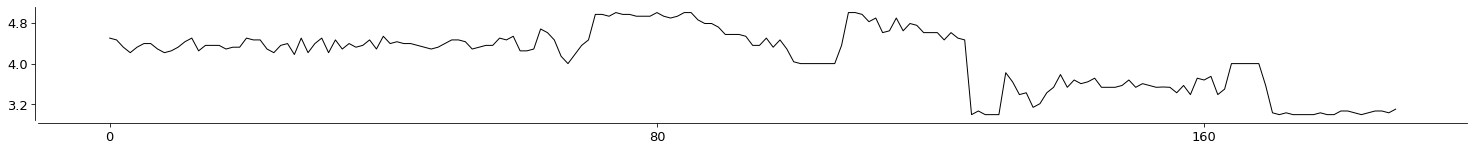

In [87]:
fig, ax = ge.figure(figsize=(3,1))
ge.plot(data['left']['movie'][:,200,200], ax=ax)
data['left']['nrepeat']

In [4]:
DATA = []
for f in FOLDERS[:3]:
    DATA.append(get_data(f))

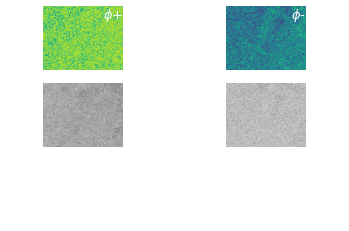

In [19]:

def show_maps(data):
    fig, AX = plt.subplots(3,2)
    
    AX[0][0].imshow(data['up']['phase_map'], cmap=plt.cm.viridis)
    AX[0][1].imshow(data['down']['phase_map'], cmap=plt.cm.viridis)
    ge.annotate(AX[0][0], '$\phi$+', (1,1), ha='right', va='top', color='w')
    ge.annotate(AX[0][1], '$\phi$-', (1,1), ha='right', va='top', color='w')
    
    AX[1][0].imshow(data['up']['power_map'], cmap=plt.cm.binary)
    AX[1][1].imshow(data['down']['power_map'], cmap=plt.cm.binary)
    
    #AX[0][1].imshow(data['left']['power_map']+data['right']['power_map'], cmap=plt.cm.binary)
    #AX[1][1].imshow(data['left']['phase_map']+data['right']['phase_map'], cmap=plt.cm.hsv)
    for ax in ge.flat(AX):
        ax.axis('off')
show_maps(DATA[0])

# Demo of FFT analysis of periodic stimulation

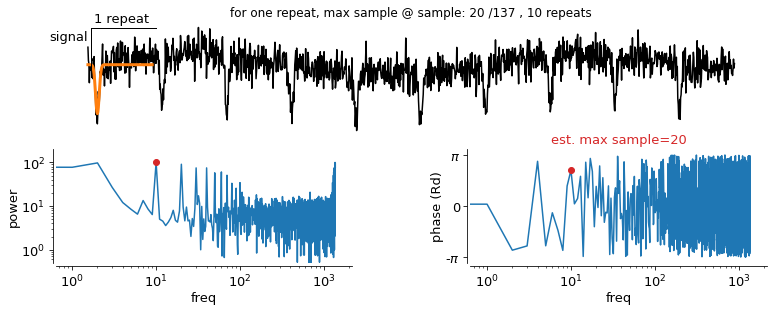

In [22]:
# demo of analysis motivation
from datavyz import graph_env_notebook as ge
import numpy as np

max_sample = 20

def from_angle_to_fraction(angle):
    return -(angle-np.pi)/2./np.pi
    
def demo_fig(max_sample,
             nrepeat=10,
             n_sample_per_repeat= 137,
             noise_fraction=0.2,
             slow_fraction=0.2,
             seed=10):
    
    np.random.seed(seed)
    fig, AX = ge.figure(axes_extents=[[[2,1]],[[1,1],[1,1]]], figsize=(1.4,1), wspace=0.7, hspace=0.2)
    x = -np.exp(-(np.arange(n_sample_per_repeat)-max_sample)**2/30)+3500
    X = np.concatenate([x for n in range(nrepeat)])
    X += noise_fraction*np.random.randn(len(X))+slow_fraction*np.sin(np.linspace(0, 10, len(X)))
    AX[0][0].plot(X, 'k-')
    AX[0][0].plot(x, lw=3, color=ge.orange)
    ge.draw_bar_scales(AX[0][0], Xbar=n_sample_per_repeat, Xbar_label='1 repeat', Ybar=1, Ybar_label='signal', remove_axis=True)
    ge.title(AX[0][0], 'for one repeat, max sample @ sample: %i /%i , %i repeats' % (max_sample, n_sample_per_repeat, nrepeat), size='small')
    spectrum = np.fft.fft(X)
    power, phase = np.abs(spectrum), np.angle(spectrum)
    AX[1][0].plot(power)
    AX[1][0].plot([nrepeat], [power[nrepeat]], 'o', color=ge.red)
    AX[1][1].plot(phase)
    AX[1][1].plot([nrepeat], [phase[nrepeat]], 'o', color=ge.red)
    ge.title(AX[1][1], 'est. max sample=%i' % (from_angle_to_fraction(phase[nrepeat])*n_sample_per_repeat), color=ge.red)
    ge.set_plot(AX[1][0], xscale='log', yscale='log', ylim=[power.min(), 2*power[nrepeat]],
                xlabel='freq', ylabel='power')
    ge.set_plot(AX[1][1], xscale='log', xlabel='freq', ylabel='phase (Rd)', yticks=[-np.pi, 0, np.pi],
               yticks_labels=['-$\pi$', '0', '$\pi$'])
    return fig

demo_fig(20, seed=3);

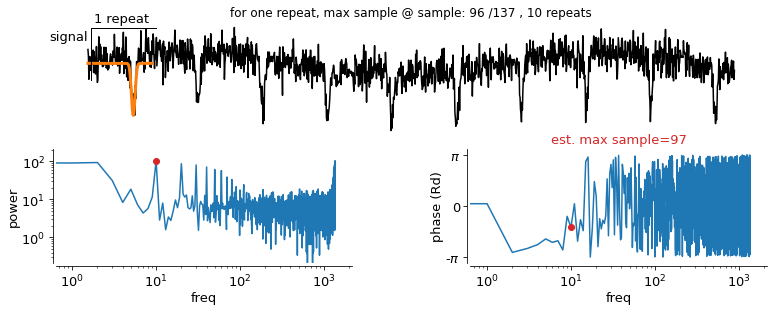

In [23]:
demo_fig(96);

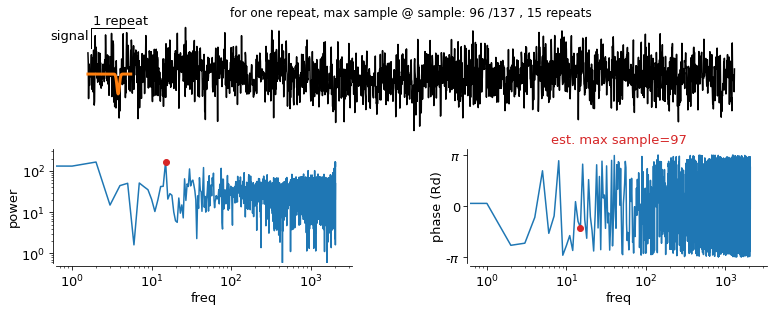

In [24]:
demo_fig(96, noise_fraction=0.8, nrepeat=15);